### Libraries

In [7]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objs as go
import folium as folium
from plotly.subplots import make_subplots
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
import plotly.offline as py
from datetime import date, timedelta
from statsmodels.tsa.arima_model import ARIMA
from sklearn.cluster import KMeans
from fbprophet import Prophet

##### Reading Data

In [8]:
path = 'D:/Desk/Kaggle Data/Source COVID-2019/'
patient_data_path = path + 'patient.csv'
route_data_path = path + 'route.csv'
time_data_path = path + 'time.csv'

df_patient = pd.read_csv(patient_data_path)
df_route = pd.read_csv(route_data_path)
df_time = pd.read_csv(time_data_path)

#### Looking into patient data

In [9]:
df_patient.head()

id     sex  birth_year country               region group  \
0  1.0  female      1984.0   China  filtered at airport   NaN   
1  2.0    male      1964.0   Korea  filtered at airport   NaN   
2  3.0    male      1966.0   Korea         capital area   NaN   
3  4.0    male      1964.0   Korea         capital area   NaN   
4  5.0    male      1987.0   Korea         capital area   NaN   

  infection_reason  infection_order  infected_by  contact_number  \
0   visit to Wuhan              1.0          NaN            45.0   
1   visit to Wuhan              1.0          NaN            75.0   
2   visit to Wuhan              1.0          NaN            16.0   
3   visit to Wuhan              1.0          NaN            95.0   
4   visit to Wuhan              1.0          NaN            31.0   

  confirmed_date released_date deceased_date     state  
0     2020-01-20    2020-02-06           NaN  released  
1     2020-01-24    2020-02-05           NaN  released  
2     2020-01-26    2020-02-12           NaN  released  
3     2020-01-27    2020-02-09           NaN  released  
4     2020-01-30    2020-03-02           NaN  released

In [10]:
df_patient.isna().sum()

id                     1
sex                 5864
birth_year          5877
country                2
region              5876
group               6202
infection_reason    6139
infection_order     6250
infected_by         6215
contact_number      6235
confirmed_date         1
released_date       6247
deceased_date       6262
state                  1
dtype: int64

In [11]:
df_patient['birth_year'] = df_patient.birth_year.fillna(0.0).astype(int)
df_patient['birth_year'] = df_patient['birth_year'].map(lambda val: val if val > 0 else np.nan)
df_patient['birth_year'].head(1000)

0      1984.0
1      1964.0
2      1966.0
3      1964.0
4      1987.0
        ...  
995    1977.0
996       NaN
997       NaN
998       NaN
999       NaN
Name: birth_year, Length: 1000, dtype: float64

In [12]:
df_patient.confirmed_date = pd.to_datetime(df_patient.confirmed_date)
daily_count = df_patient.groupby(df_patient.confirmed_date).id.count()
accumulated_count = daily_count.cumsum()

In [13]:
df_patient['age'] = 2020 - df_patient['birth_year'] 

In [14]:
import math
def group_age(age):
    if age >= 0: # not NaN
        if age % 10 != 0:
            lower = int(math.floor(age / 10.0)) * 10
            upper = int(math.ceil(age / 10.0)) * 10 - 1
            return f"{lower}-{upper}"
        else:
            lower = int(age)
            upper = int(age + 9) 
            return f"{lower}-{upper}"
    return "Unknown"


df_patient["age_range"] = df_patient["age"].apply(group_age)

In [15]:
for i, row in df_patient.iterrows():
    if df_patient.loc[i, 'age'] != 0:
         df_patient.loc[i, 'age']

In [16]:
patient=df_patient

#### Preprocessing

In [17]:
date_cols = ["confirmed_date", "released_date", "deceased_date"]
for col in date_cols:
    patient[col] = pd.to_datetime(patient[col])

In [18]:
patient["time_to_release_since_confirmed"] = patient["released_date"] - patient["confirmed_date"]

patient["time_to_death_since_confirmed"] = patient["deceased_date"] - patient["confirmed_date"]
patient["duration_since_confirmed"] = patient[["time_to_release_since_confirmed", "time_to_death_since_confirmed"]].min(axis=1)
patient["duration_days"] = patient["duration_since_confirmed"].dt.days
age_ranges = sorted(set([ar for ar in patient["age_range"] if ar != "Unknown"]))
patient["state_by_gender"] = patient["state"] + "_" + patient["sex"]

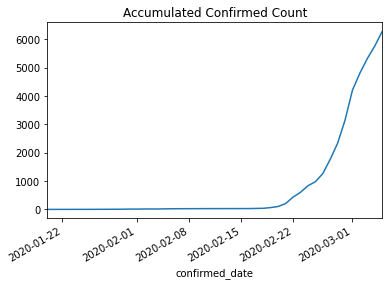

In [19]:
accumulated_count.plot()
plt.title('Accumulated Confirmed Count');

#### Current State of Patient

In [20]:
infected_patient = patient.shape[0]
rp = patient.loc[patient["state"] == "released"].shape[0]
dp = patient.loc[patient["state"] == "deceased"].shape[0]
ip = patient.loc[patient["state"]== "isolated"].shape[0]
rp=rp/patient.shape[0]
dp=dp/patient.shape[0]
ip=ip/patient.shape[0]
print("The percentage of recovery is "+ str(rp*100) )
print("The percentage of deceased is "+ str(dp*100) )
print("The percentage of isolated is "+ str(ip*100) )

The percentage of recovery is 0.6364359586316627
The percentage of deceased is 0.36595067621320604
The percentage of isolated is 98.98170246618933


In [21]:
states = pd.DataFrame(patient["state"].value_counts())
states["status"] = states.index
states.rename(columns={"state": "count"}, inplace=True)

fig = px.pie(states,
             values="count",
             names="status",
             title="Current state of patients",
             template="seaborn")
fig.update_traces(rotation=90, pull=0.05, textinfo="value+percent+label")
fig.show()

#### People who released

In [22]:
released = df_patient[df_patient.state == 'released']
released.head()

id     sex  birth_year country               region group  \
0  1.0  female      1984.0   China  filtered at airport   NaN   
1  2.0    male      1964.0   Korea  filtered at airport   NaN   
2  3.0    male      1966.0   Korea         capital area   NaN   
3  4.0    male      1964.0   Korea         capital area   NaN   
4  5.0    male      1987.0   Korea         capital area   NaN   

  infection_reason  infection_order  infected_by  contact_number  ...  \
0   visit to Wuhan              1.0          NaN            45.0  ...   
1   visit to Wuhan              1.0          NaN            75.0  ...   
2   visit to Wuhan              1.0          NaN            16.0  ...   
3   visit to Wuhan              1.0          NaN            95.0  ...   
4   visit to Wuhan              1.0          NaN            31.0  ...   

  released_date deceased_date     state   age  age_range  \
0    2020-02-06           NaT  released  36.0      30-39   
1    2020-02-05           NaT  released  56.0      50-59   
2    2020-02-12           NaT  released  54.0      50-59   
3    2020-02-09           NaT  released  56.0      50-59   
4    2020-03-02           NaT  released  33.0      30-39   

  time_to_release_since_confirmed time_to_death_since_confirmed  \
0                         17 days                           NaT   
1                         12 days                           NaT   
2                         17 days                           NaT   
3                         13 days                           NaT   
4                         32 days                           NaT   

  duration_since_confirmed duration_days  state_by_gender  
0                  17 days          17.0  released_female  
1                  12 days          12.0    released_male  
2                  17 days          17.0    released_male  
3                  13 days          13.0    released_male  
4                  32 days          32.0    released_male  

[5 rows x 21 columns]

#### People who are in isolated state

In [23]:
isolated_state = df_patient[df_patient.state == 'isolated']
isolated_state.head()

id     sex  birth_year country        region group  \
24  25.0  female      1946.0   Korea  capital area   NaN   
25  26.0    male      1968.0   Korea  capital area   NaN   
26  27.0  female      1982.0   China  capital area   NaN   
28  29.0    male      1938.0   Korea  capital area   NaN   
29  30.0  female      1952.0   Korea  capital area   NaN   

        infection_reason  infection_order  infected_by  contact_number  ...  \
24  contact with patient              2.0         27.0            12.0  ...   
25  contact with patient              1.0         27.0             0.0  ...   
26        visit to China              1.0          NaN            40.0  ...   
28  contact with patient              4.0         83.0           117.0  ...   
29  contact with patient              5.0         29.0            27.0  ...   

   released_date deceased_date     state   age  age_range  \
24           NaT           NaT  isolated  74.0      70-79   
25           NaT           NaT  isolated  52.0      50-59   
26           NaT           NaT  isolated  38.0      30-39   
28           NaT           NaT  isolated  82.0      80-89   
29           NaT           NaT  isolated  68.0      60-69   

   time_to_release_since_confirmed time_to_death_since_confirmed  \
24                             NaT                           NaT   
25                             NaT                           NaT   
26                             NaT                           NaT   
28                             NaT                           NaT   
29                             NaT                           NaT   

   duration_since_confirmed duration_days  state_by_gender  
24                      NaT           NaN  isolated_female  
25                      NaT           NaN    isolated_male  
26                      NaT           NaN  isolated_female  
28                      NaT           NaN    isolated_male  
29                      NaT           NaN  isolated_female  

[5 rows x 21 columns]

#### Patient who died

In [24]:
dead = df_patient[df_patient.state == 'deceased']
dead.head()

id     sex  birth_year country            region  \
37    38.0  female      1963.0   Korea             Daegu   
53    54.0    male      1963.0   Korea  Gyeongsangbuk-do   
54    55.0    male      1961.0   Korea  Gyeongsangbuk-do   
103  104.0    male      1957.0   Korea  Gyeongsangbuk-do   
106  107.0    male      1953.0   Korea  Gyeongsangbuk-do   

                        group infection_reason  infection_order  infected_by  \
37                        NaN              NaN              NaN          NaN   
53   Cheongdo Daenam Hospital              NaN              NaN          NaN   
54   Cheongdo Daenam Hospital              NaN              NaN          NaN   
103  Cheongdo Daenam Hospital              NaN              NaN          NaN   
106  Cheongdo Daenam Hospital              NaN              NaN          NaN   

     contact_number  ... released_date deceased_date     state   age  \
37              NaN  ...           NaT    2020-02-23  deceased  57.0   
53              NaN  ...           NaT    2020-02-23  deceased  57.0   
54              NaN  ...           NaT    2020-02-23  deceased  59.0   
103             NaN  ...           NaT    2020-02-19  deceased  63.0   
106             NaN  ...           NaT    2020-02-24  deceased  67.0   

     age_range time_to_release_since_confirmed time_to_death_since_confirmed  \
37       50-59                             NaT                        5 days   
53       50-59                             NaT                        4 days   
54       50-59                             NaT                        4 days   
103      60-69                             NaT                       -1 days   
106      60-69                             NaT                        3 days   

    duration_since_confirmed duration_days  state_by_gender  
37                    5 days           5.0  deceased_female  
53                    4 days           4.0    deceased_male  
54                    4 days           4.0    deceased_male  
103                  -1 days          -1.0    deceased_male  
106                   3 days           3.0    deceased_male  

[5 rows x 21 columns]

#### Age distribution of the released

<AxesSubplot:title={'center':'Age distribution of the released'}>

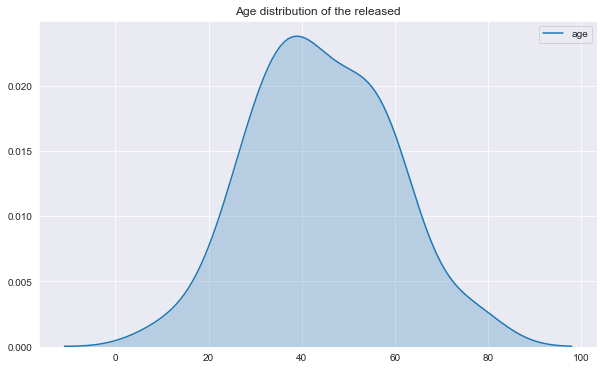

In [25]:
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.title("Age distribution of the released")
sns.kdeplot(data=released['age'], shade=True)

#### Age distribution of isolated person

<AxesSubplot:title={'center':'Age distribution of the isolated'}>

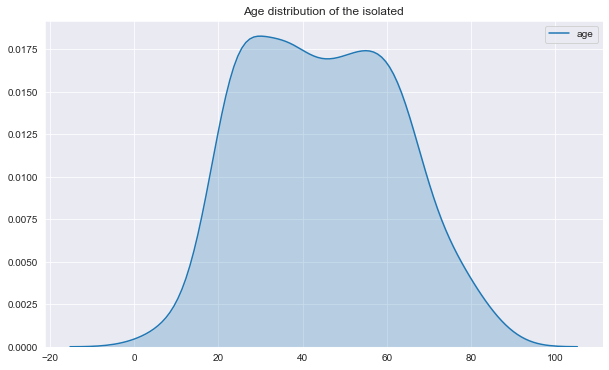

In [26]:
np.warnings.filterwarnings('ignore')
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.title("Age distribution of the isolated")
sns.kdeplot(data=isolated_state['age'], shade=True)

In [27]:
##for i, row in isolated_state.iterrows():
##    if np.isnan(isolated_state.loc[i, 'age']):
##       isolated_state.at[i, 'age'] = 0
for i, row in isolated_state.iterrows():
    if isolated_state.loc[i, 'age'] == 0:
        isolated_state.at[i, 'age'] = np.nan

In [28]:
for i, row in isolated_state.iterrows():
    if np.isnan(isolated_state.loc[i, 'age']):
         isolated_state.loc[i, 'age']

#### Age distribution of death

<AxesSubplot:title={'center':'Age distribution of the deceased'}>

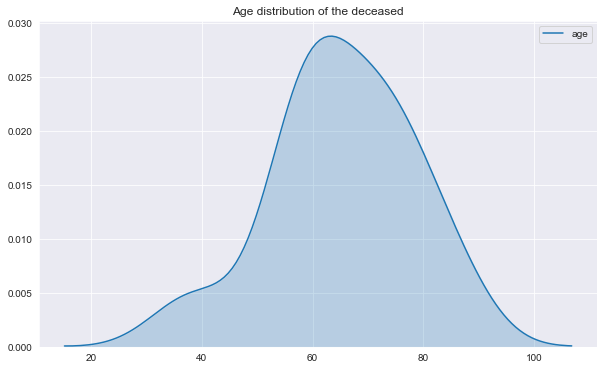

In [29]:
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.title("Age distribution of the deceased")
sns.kdeplot(data=dead['age'], shade=True)

In [30]:
male_dead = dead[dead.sex=='male']
female_dead = dead[dead.sex=='female']

#### Age distribution of death by gender

<AxesSubplot:title={'center':'Age distribution of the deceased by gender'}>

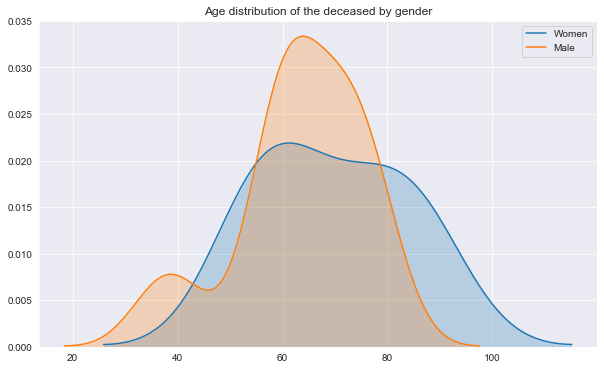

In [31]:
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.title("Age distribution of the deceased by gender")
sns.kdeplot(data=female_dead['age'], label="Women", shade=True)
sns.kdeplot(data=male_dead['age'],label="Male" ,shade=True)

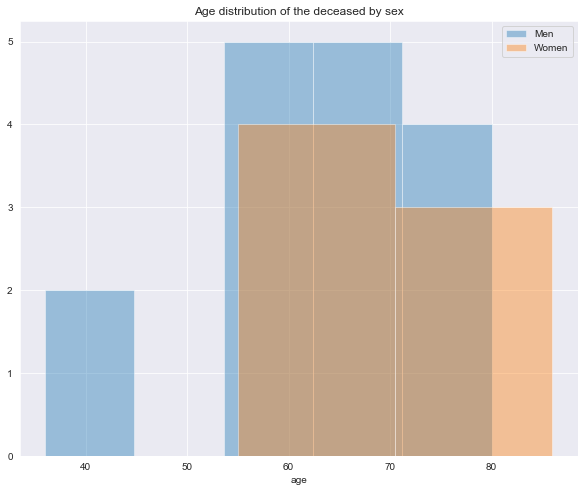

In [32]:
plt.figure(figsize=(10,8))
sns.set_style("darkgrid")
sns.distplot(a=male_dead['age'], label="Men", kde=False)
sns.distplot(a=female_dead['age'], label="Women", kde=False)
plt.title("Age distribution of the deceased by sex")
plt.legend()

#### Comparison of released and deceased by age

<AxesSubplot:>

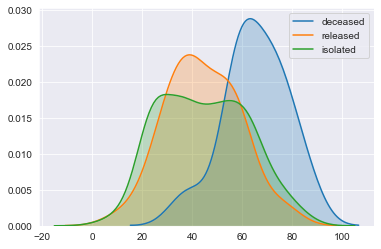

In [33]:
sns.kdeplot(data=dead['age'],label='deceased', shade=True)
sns.kdeplot(data=released['age'],label='released', shade=True)
sns.kdeplot(data=isolated_state['age'],label='isolated', shade=True)

#### Death by gender

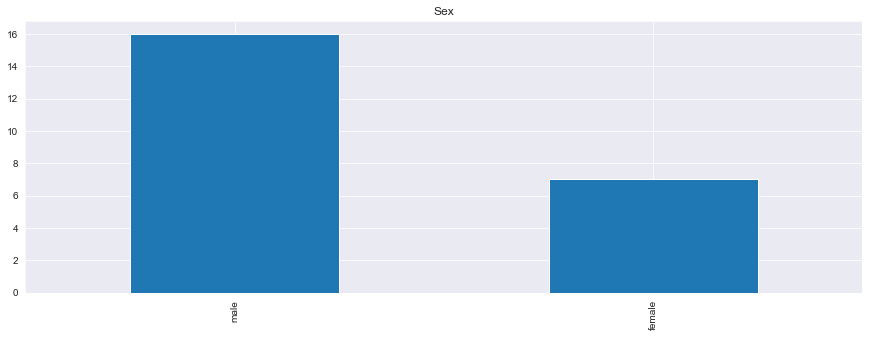

In [34]:
plt.figure(figsize=(15, 5))
plt.title('Sex')
dead.sex.value_counts().plot.bar();

#### Reason for the infection

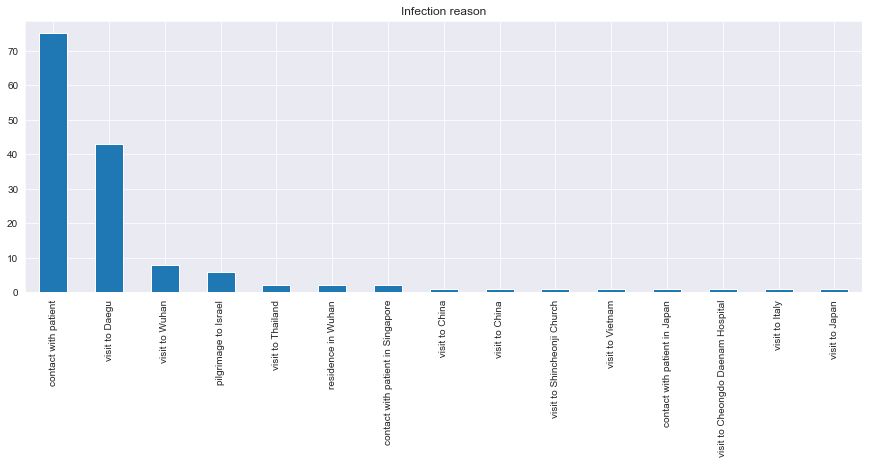

In [35]:
        plt.figure(figsize=(15,5))
plt.title('Infection reason')
df_patient.infection_reason.value_counts().plot.bar();

#### State of Patient

<AxesSubplot:xlabel='state', ylabel='count'>

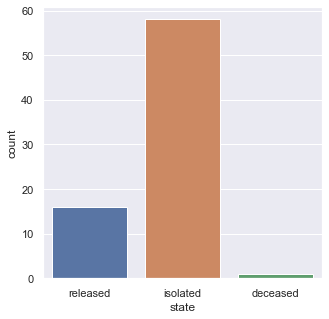

In [36]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x=df_patient['state'].loc[
    (df_patient['infection_reason']=='contact with patient')
])

#### State of male patient

<AxesSubplot:xlabel='state', ylabel='count'>

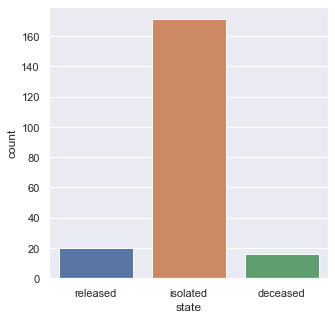

In [37]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x=df_patient['state'].loc[(df_patient['sex']=="male")])

#### State of female patient

<AxesSubplot:xlabel='state', ylabel='count'>

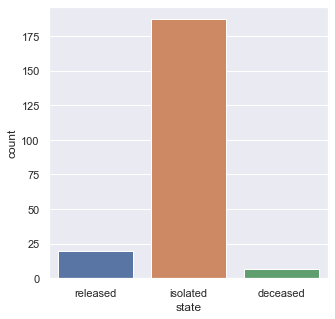

In [38]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x=df_patient['state'].loc[(df_patient['sex']=="female")])

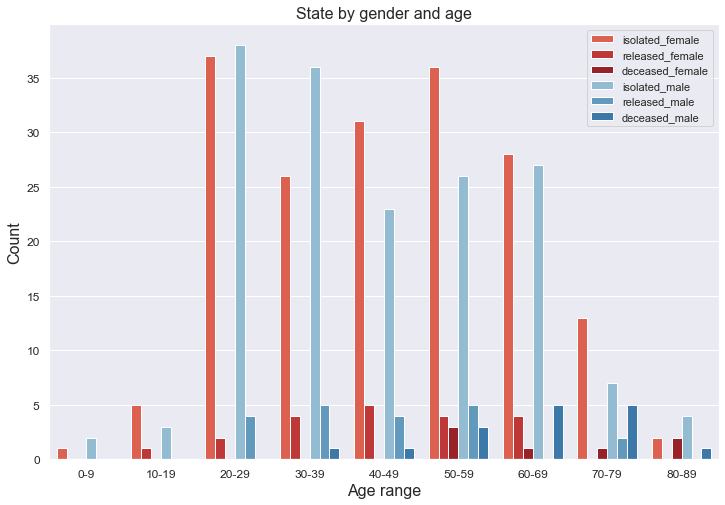

In [39]:
age_gender_hue_order =["isolated_female", "released_female", "deceased_female",
                       "isolated_male", "released_male", "deceased_male"]
custom_palette = sns.color_palette("Reds")[3:6] + sns.color_palette("Blues")[2:5]

plt.figure(figsize=(12, 8))
sns.countplot(x = "age_range",
              hue="state_by_gender",
              order=age_ranges,
              hue_order=age_gender_hue_order,
              palette=custom_palette,
              data=patient)
plt.title("State by gender and age", fontsize=16)
plt.xlabel("Age range", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="upper right")
plt.show()

#### Looking route data

In [40]:
df_route.head()

id        date     province      city              visit   latitude  \
0   1  2020-01-19      Incheon   Jung-gu            airport  37.460459   
1   1  2020-01-20      Incheon    Seo-gu  hospital_isolated  37.478832   
2   2  2020-01-22  Gyeonggi-do  Gimpo-si            airport  37.562143   
3   2  2020-01-23        Seoul   Jung-gu  hospital_isolated  37.567454   
4   3  2020-01-20      Incheon   Jung-gu            airport  37.460459   

    longitude  
0  126.440680  
1  126.668558  
2  126.801884  
3  127.005627  
4  126.440680

#### Checking if is there any null value

In [41]:
df_route.isna().sum()

id           0
date         0
province     0
city         0
visit        0
latitude     0
longitude    0
dtype: int64

In [42]:
clus=df_route.loc[:,['id','latitude','longitude']]
clus.head(10)

id   latitude   longitude
0   1  37.460459  126.440680
1   1  37.478832  126.668558
2   2  37.562143  126.801884
3   2  37.567454  127.005627
4   3  37.460459  126.440680
5   3  37.524978  127.027718
6   3  37.503359  127.049177
7   3  37.524669  127.015911
8   3  37.529200  127.032597
9   3  37.674192  126.776955

#### Checking for number of cluster

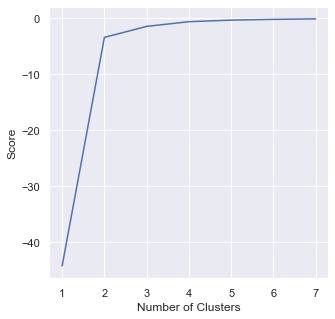

In [43]:
K_clusters = range(1,8)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df_route[['latitude']]
X_axis = df_route[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

In [44]:
kmeans = KMeans(n_clusters = 4, init ='k-means++')
kmeans.fit(clus[clus.columns[1:3]])
clus['cluster_label'] = kmeans.fit_predict(clus[clus.columns[1:3]])
centers = kmeans.cluster_centers_
labels = kmeans.predict(clus[clus.columns[1:3]])

#### Graphical representation of clusters

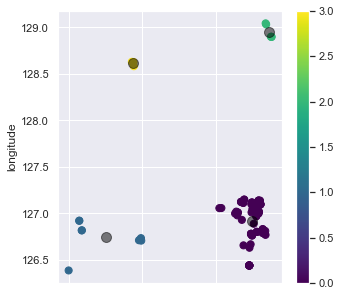

In [45]:
clus.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)

#### We will verify our clusters by putting values in world map by making use of folium library

#### Affected place in world map

In [46]:
southkorea_map = folium.Map(location=[36.55,126.983333 ], zoom_start=7,tiles='Stamen Toner')

for lat, lon,city in zip(df_route['latitude'], df_route['longitude'],df_route['city']):
    folium.CircleMarker([lat, lon],
                        radius=5,
                        color='red',
                      popup =('City: ' + str(city) + '<br>'),
                        fill_color='red',
                        fill_opacity=0.7 ).add_to(southkorea_map)
southkorea_map

#### Patient in city

In [47]:
df_route

id        date     province             city              visit  \
0     1  2020-01-19      Incheon          Jung-gu            airport   
1     1  2020-01-20      Incheon           Seo-gu  hospital_isolated   
2     2  2020-01-22  Gyeonggi-do         Gimpo-si            airport   
3     2  2020-01-23        Seoul          Jung-gu  hospital_isolated   
4     3  2020-01-20      Incheon          Jung-gu            airport   
..   ..         ...          ...              ...                ...   
97   19  2020-02-05        Seoul      Jungnang-gu  hospital_isolated   
98   20  2020-02-05        Seoul  Yeongdeungpo-gu            company   
99   20  2020-02-05  Gyeonggi-do         Suwon-si                etc   
100  20  2020-02-05  Gyeonggi-do         Suwon-si           hospital   
101  20  2020-02-06  Gyeonggi-do      Seongnam-si  hospital_isolated   

      latitude   longitude  
0    37.460459  126.440680  
1    37.478832  126.668558  
2    37.562143  126.801884  
3    37.567454  127.005627  
4    37.460459  126.440680  
..         ...         ...  
97   37.613102  127.098658  
98   37.521024  126.889323  
99   37.296669  126.979570  
100  37.304439  127.010123  
101  37.391762  127.148825  

[102 rows x 7 columns]

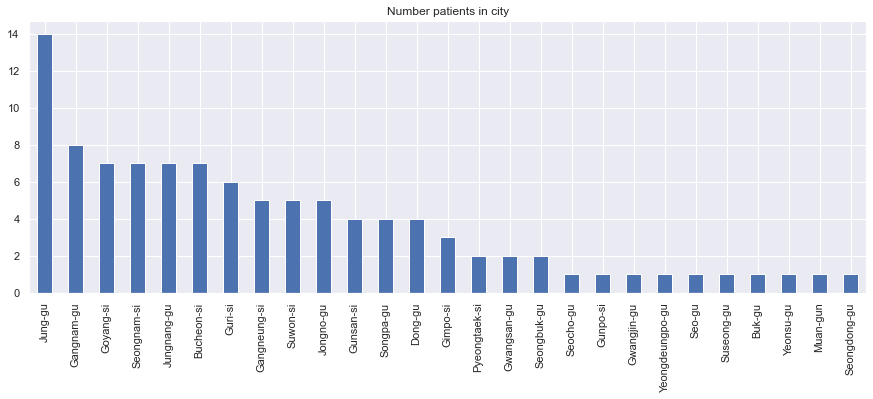

In [48]:
plt.figure(figsize=(15,5))
plt.title('Number patients in city')
df_route.city.value_counts().plot.bar();

#### Patients in Provience/State

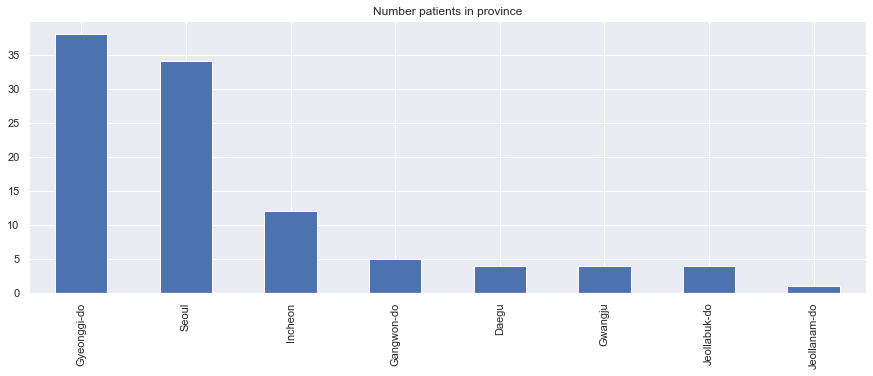

In [49]:
plt.figure(figsize=(15,5))
plt.title('Number patients in province')
df_route.province.value_counts().plot.bar();

#### Places where people get affected

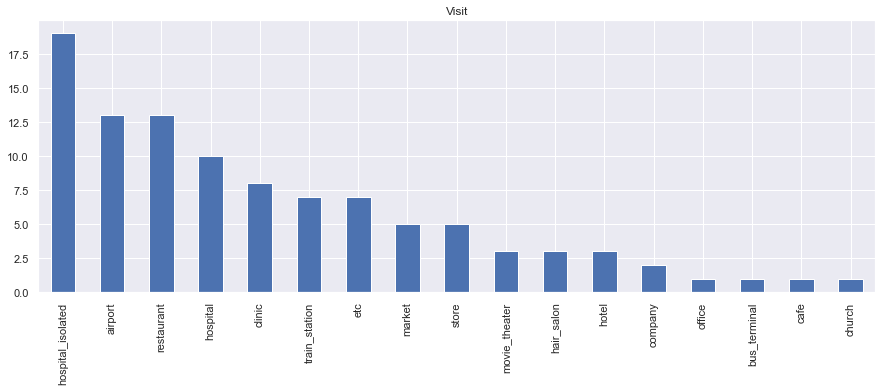

In [50]:
plt.figure(figsize=(15,5))
plt.title('Visit')
df_route.visit.value_counts().plot.bar();

#### Time from confirmation to release or death

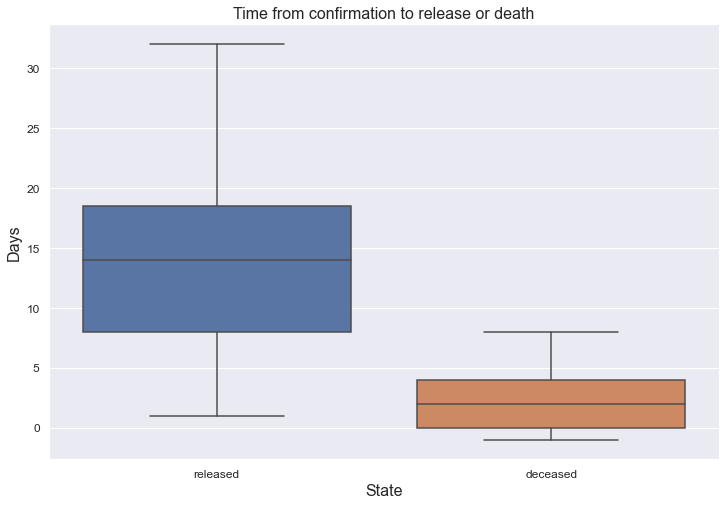

In [51]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="state",
            y="duration_days",
            order=["released", "deceased"],
            data=patient)
plt.title("Time from confirmation to release or death", fontsize=16)
plt.xlabel("State", fontsize=16)
plt.ylabel("Days", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

#### Time from confirmation to release or death by gender

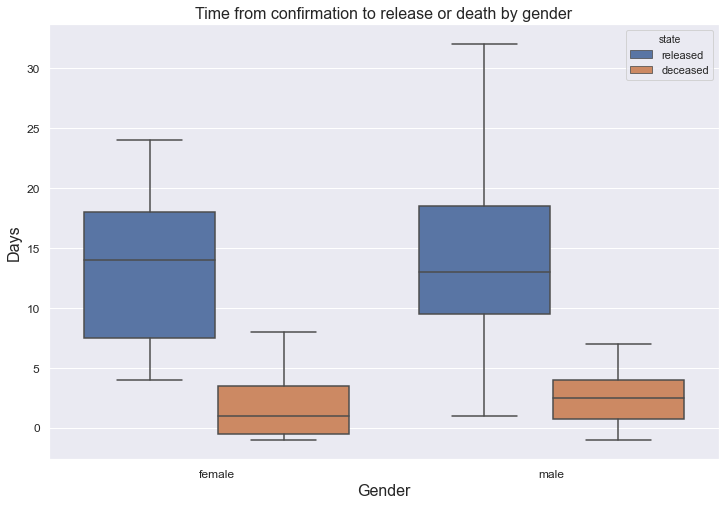

In [52]:
order_duration_sex = ["female", "male"]
plt.figure(figsize=(12, 8))
sns.boxplot(x="sex",
            y="duration_days",
            order=order_duration_sex,
            hue="state",            
            hue_order=["released", "deceased"],
            data=patient)
plt.title("Time from confirmation to release or death by gender",
          fontsize=16)
plt.xlabel("Gender", fontsize=16)
plt.ylabel("Days", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

#### Time from confirmation to release or death

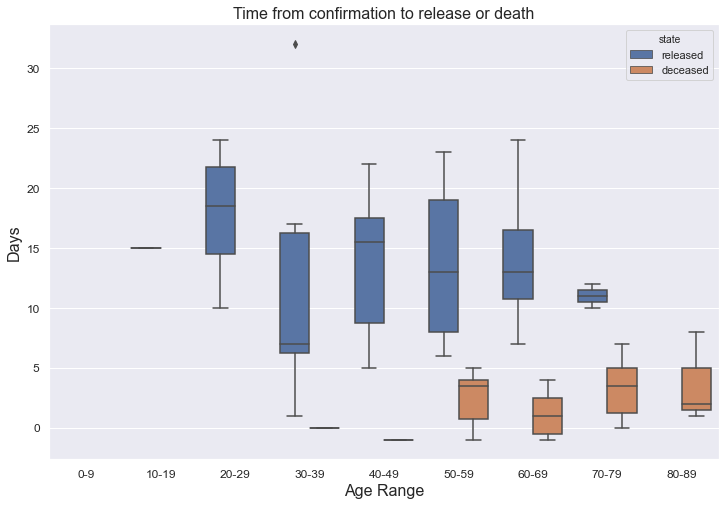

In [53]:
order_duration_age = sorted(patient["age_range"].unique())[:-1]
plt.figure(figsize=(12, 8))
sns.boxplot(x="age_range",
            y="duration_days",
            order=order_duration_age,
            hue="state",
            hue_order=["released", "deceased"],
            data=patient)
plt.title("Time from confirmation to release or death", fontsize=16)
plt.xlabel("Age Range", fontsize=16)
plt.ylabel("Days", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

#### Making data ready for prediction

In [54]:
data = daily_count.resample('D').first().fillna(0).cumsum()
data = data[20:]
x = np.arange(len(data)).reshape(-1, 1)
y = data.values
daily_count.head(100)

confirmed_date
2020-01-20       1
2020-01-24       1
2020-01-26       1
2020-01-27       1
2020-01-30       3
2020-01-31       4
2020-02-01       1
2020-02-02       3
2020-02-04       1
2020-02-05       5
2020-02-06       3
2020-02-09       3
2020-02-10       1
2020-02-16       2
2020-02-18       9
2020-02-19      26
2020-02-20      38
2020-02-21     100
2020-02-22     229
2020-02-23     169
2020-02-24     231
2020-02-25     143
2020-02-26     285
2020-02-27     505
2020-02-28     571
2020-02-29     813
2020-03-01    1062
2020-03-02     600
2020-03-03     516
2020-03-04     438
2020-03-05     518
Name: id, dtype: int64

#### Regression Model

In [55]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=[32, 32, 10], max_iter=50000, alpha=0.0005, random_state=26)
_=model.fit(x, y)

In [56]:
test = np.arange(len(data)+7).reshape(-1, 1)
pred = model.predict(test)
prediction = pred.round().astype(int)
week = [data.index[0] + timedelta(days=i) for i in range(len(prediction))]
dt_idx = pd.DatetimeIndex(week)
predicted_count = pd.Series(prediction, dt_idx)

#### Graphical representatoin of current confirmed and predicted confirmed

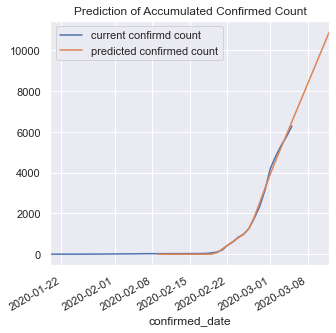

In [57]:
accumulated_count.plot()
predicted_count.plot()
plt.title('Prediction of Accumulated Confirmed Count')
plt.legend(['current confirmd count', 'predicted confirmed count'])
plt.show()

#### Prophet

In [58]:
prophet= pd.DataFrame(data)
prophet
pr_data = prophet.reset_index()
pr_data.columns = ['ds','y']
pr_data.head()

ds     y
0 2020-02-09  27.0
1 2020-02-10  28.0
2 2020-02-11  28.0
3 2020-02-12  28.0
4 2020-02-13  28.0

#### Prediction

In [59]:
m=Prophet()
m.fit(pr_data)
future=m.make_future_dataframe(periods=365)
forecast=m.predict(future)
forecast

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


ds         trend    yhat_lower    yhat_upper   trend_lower  \
0   2020-02-09  -1470.560573  -2474.935821     33.539081  -1470.560573   
1   2020-02-10  -1237.340541  -2254.673105    203.970972  -1237.340541   
2   2020-02-11  -1004.120508  -2186.346079    428.773999  -1004.120508   
3   2020-02-12   -770.900476  -1983.422772    700.361141   -770.900476   
4   2020-02-13   -537.680443  -1678.607405    874.745735   -537.680443   
..         ...           ...           ...           ...           ...   
386 2021-03-01  88566.389717  87539.497919  90029.373825  88554.549318   
387 2021-03-02  88799.647276  87651.788450  90244.452920  88787.773457   
388 2021-03-03  89032.904834  87867.781882  90354.165036  89020.989521   
389 2021-03-04  89266.162393  88055.171576  90613.710895  89254.195903   
390 2021-03-05  89499.419951  87883.679094  90357.739166  89487.402073   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    -1470.560573      238.502984            238.502984            238.502984   
1    -1237.340541      213.160367            213.160367            213.160367   
2    -1004.120508      146.818561            146.818561            146.818561   
3     -770.900476      100.687201            100.687201            100.687201   
4     -537.680443      132.555985            132.555985            132.555985   
..            ...             ...                   ...                   ...   
386  88578.024620      213.160367            213.160367            213.160367   
387  88811.337418      146.818561            146.818561            146.818561   
388  89044.608276      100.687201            100.687201            100.687201   
389  89277.877335      132.555985            132.555985            132.555985   
390  89511.160119     -472.854241           -472.854241           -472.854241   

         weekly  weekly_lower  weekly_upper  multiplicative_terms  \
0    238.502984    238.502984    238.502984                   0.0   
1    213.160367    213.160367    213.160367                   0.0   
2    146.818561    146.818561    146.818561                   0.0   
3    100.687201    100.687201    100.687201                   0.0   
4    132.555985    132.555985    132.555985                   0.0   
..          ...           ...           ...                   ...   
386  213.160367    213.160367    213.160367                   0.0   
387  146.818561    146.818561    146.818561                   0.0   
388  100.687201    100.687201    100.687201                   0.0   
389  132.555985    132.555985    132.555985                   0.0   
390 -472.854241   -472.854241   -472.854241                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                           0.0                         0.0  -1232.057589  
1                           0.0                         0.0  -1024.180174  
2                           0.0                         0.0   -857.301947  
3                           0.0                         0.0   -670.213275  
4                           0.0                         0.0   -405.124458  
..                          ...                         ...           ...  
386                         0.0                         0.0  88779.550084  
387                         0.0                         0.0  88946.465837  
388                         0.0                         0.0  89133.592035  
389                         0.0                         0.0  89398.718378  
390                         0.0                         0.0  89026.565710  

[391 rows x 16 columns]

#### Graphical Representation of Prediction

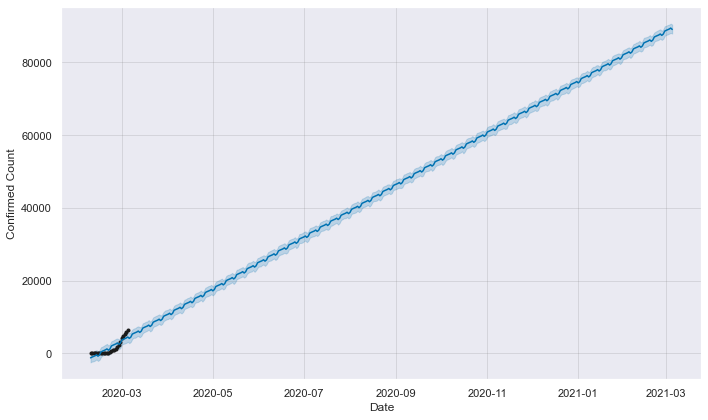

In [60]:
figure = plot_plotly(m, forecast)
py.iplot(figure) 

figure = m.plot(forecast,xlabel='Date',ylabel='Confirmed Count')

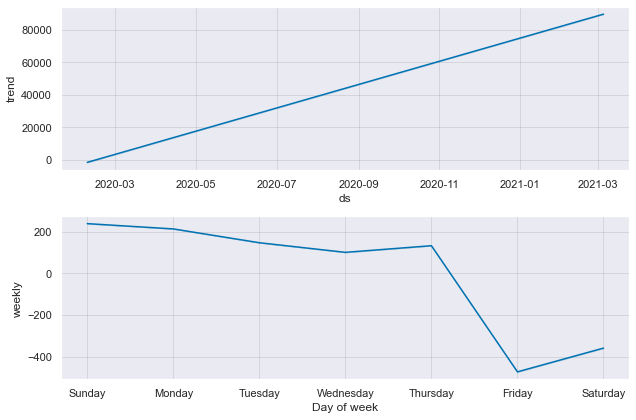

In [61]:
figure=m.plot_components(forecast)

#### Autoregressive integrated moving average(Arima)

In [62]:
confirm_cs = pd.DataFrame(data).cumsum()
arima_data = confirm_cs.reset_index()
arima_data.columns = ['confirmed_date','count']
arima_data.head()

confirmed_date  count
0     2020-02-09   27.0
1     2020-02-10   55.0
2     2020-02-11   83.0
3     2020-02-12  111.0
4     2020-02-13  139.0

In [63]:
model = ARIMA(arima_data['count'].values, order=(1, 2, 1))
fit_model = model.fit(trend='c', full_output=True, disp=True)
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                   24
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -152.753
Method:                       css-mle   S.D. of innovations            136.229
Date:                Thu, 13 Aug 2020   AIC                            313.506
Time:                        22:39:26   BIC                            318.218
Sample:                             2   HQIC                           314.756
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        261.8480    172.986      1.514      0.145     -77.199     600.895
ar.L1.D2.y     0.8522      0.110      7.751      0.000       0.637       1.068
ma.L1.D2.y     0.1221      0.226      0.540      0.595      -0.321       0.566
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1735           +0.0000j            1.1735            0.0000
MA.1           -8.1880           +0.0000j            8.1880            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:>

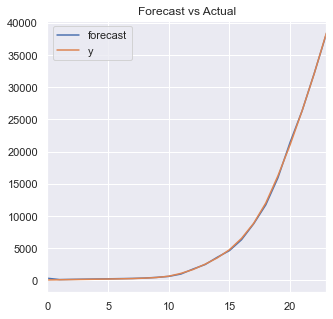

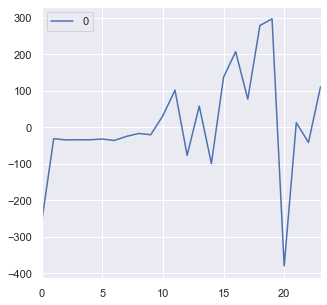

In [64]:
fit_model.plot_predict()
plt.title('Forecast vs Actual')
pd.DataFrame(fit_model.resid).plot()

#### Forecasting future Values

In [65]:
forcast = fit_model.forecast(steps=5)
pred_y = forcast[0].tolist()
pd.DataFrame(pred_y)

0
0  45188.708995
1  52424.850654
2  60091.215762
3  68162.913145
4  76618.731324

#### Looking into time data

In [66]:
df_time.rename(columns={'176':'date'}, 
                 inplace=True)

In [67]:
df_time.shape

(46, 11)

In [68]:
df_time.head()

date  acc_test  acc_negative  acc_confirmed  acc_released  \
0  2020-01-20         1             0              1             0   
1  2020-01-21         1             0              1             0   
2  2020-01-22         4             3              1             0   
3  2020-01-23        22            21              1             0   
4  2020-01-24        27            25              2             0   

   acc_deceased  new_test  new_negative  new_confirmed  new_released  \
0             0         1             0              1             0   
1             0         0             0              0             0   
2             0         3             3              0             0   
3             0        18            18              0             0   
4             0         5             4              1             0   

   new_deceased  
0             0  
1             0  
2             0  
3             0  
4             0

In [69]:
confirm_perc=(df_time['acc_confirmed'].sum()+ df_time['new_confirmed'].sum())/(df_time['acc_test'].sum() + df_time['new_test'].sum())*100
released_perc=(df_time['acc_released'].sum()+ df_time['new_released'].sum())/(df_time['acc_test'].sum() + df_time['new_test'].sum())*100
deceased_perc=(df_time['acc_deceased'].sum()+ df_time['new_deceased'].sum())/(df_time['acc_test'].sum() + df_time['new_test'].sum())*100

In [70]:
print("The percentage of confirm  is "+ str(confirm_perc) )
print("The percentage of released is "+ str(released_perc) )
print("The percentage of deceased is "+ str(deceased_perc) )

The percentage of confirm  is 3.260141491956986
The percentage of released is 0.052888757797096064
The percentage of deceased is 0.02106832384774431


#### Graphical representaion of People Test and Confirmed

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


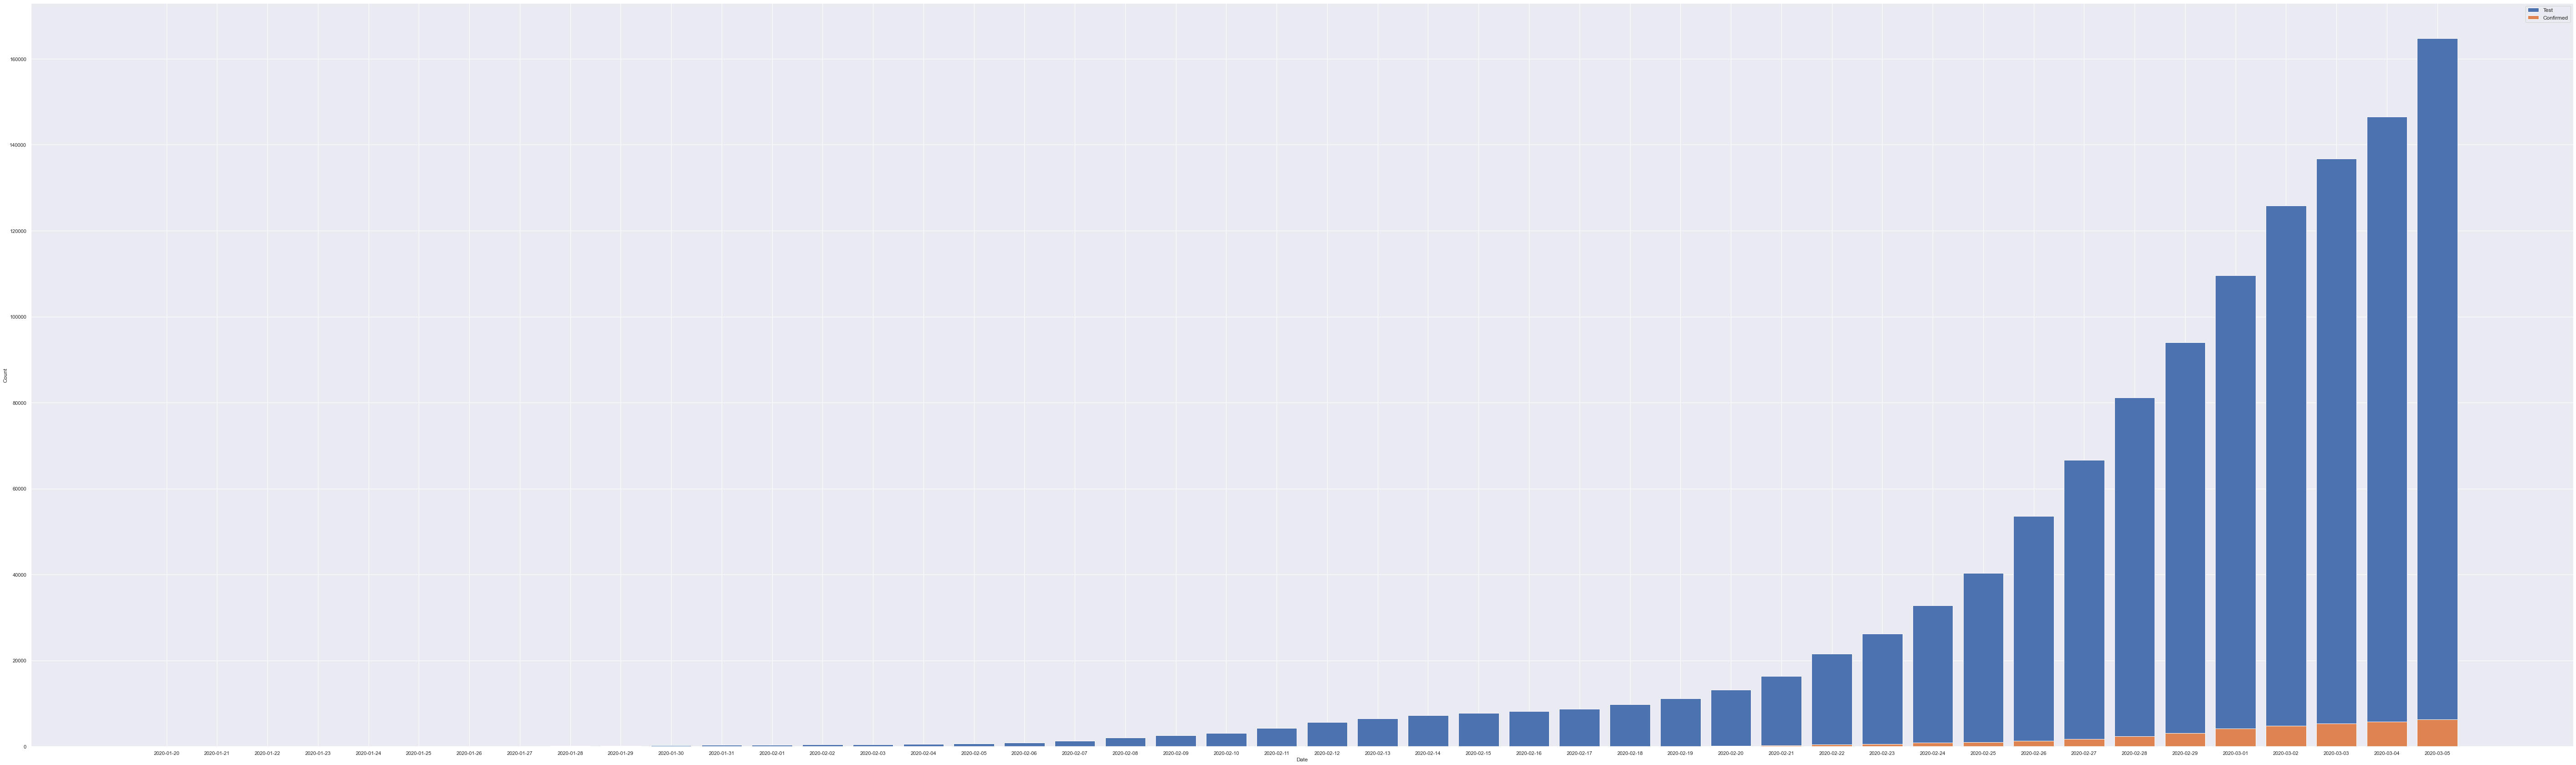

In [71]:
plt.figure(figsize=(100,30))
plt.bar(df_time.date, df_time.acc_test,label="Test")
plt.bar(df_time.date, df_time.acc_confirmed, label = "Confirmed")
plt.xlabel('Date')
plt.ylabel("Count")
plt.legend(frameon=True, fontsize=12)
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

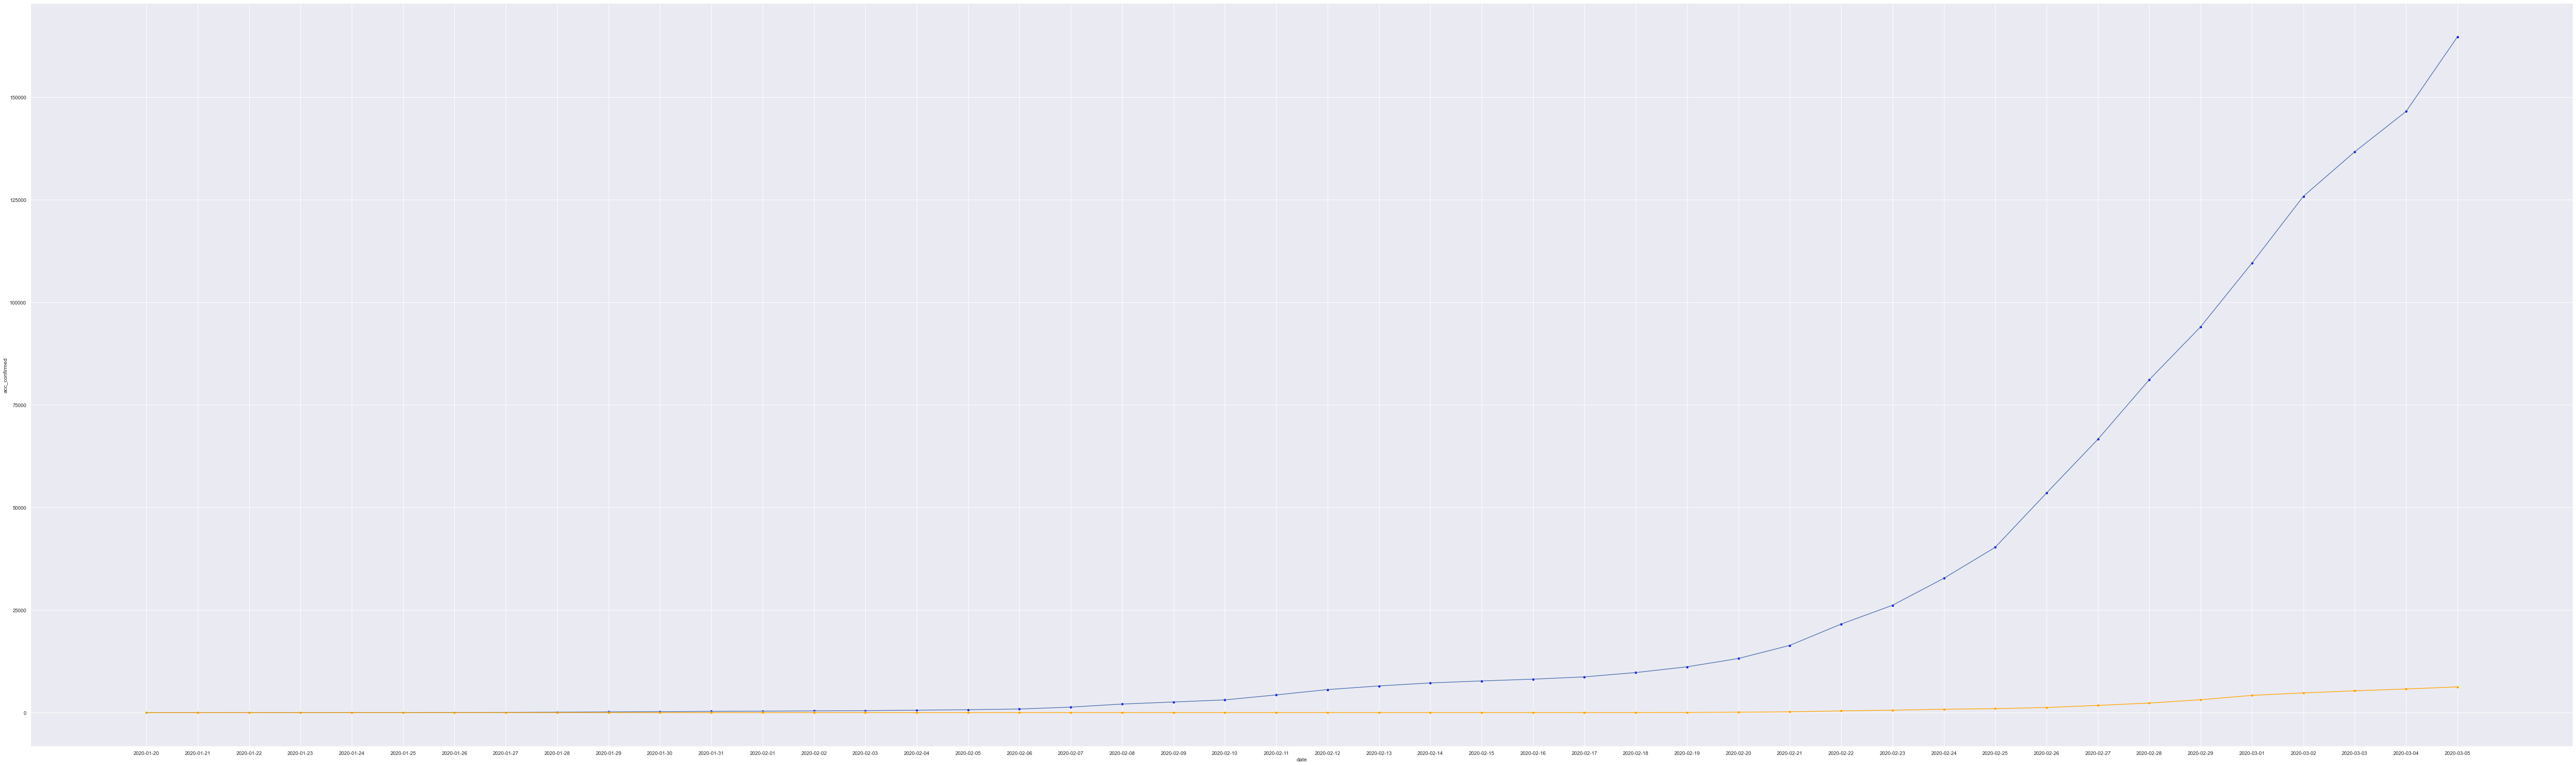

In [72]:
f, ax = plt.subplots(figsize=(100, 30))
ax=sns.scatterplot(x="date", y="acc_test", data=df_time,
             color="blue")
ax=sns.scatterplot(x="date", y="acc_confirmed", data=df_time,
             color="orange")


plt.plot(df_time.date,df_time.acc_test,zorder=1)
plt.plot(df_time.date,df_time.acc_confirmed,zorder=1,color="orange")

#### Graphical representaion of new People Test and Confirmed

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


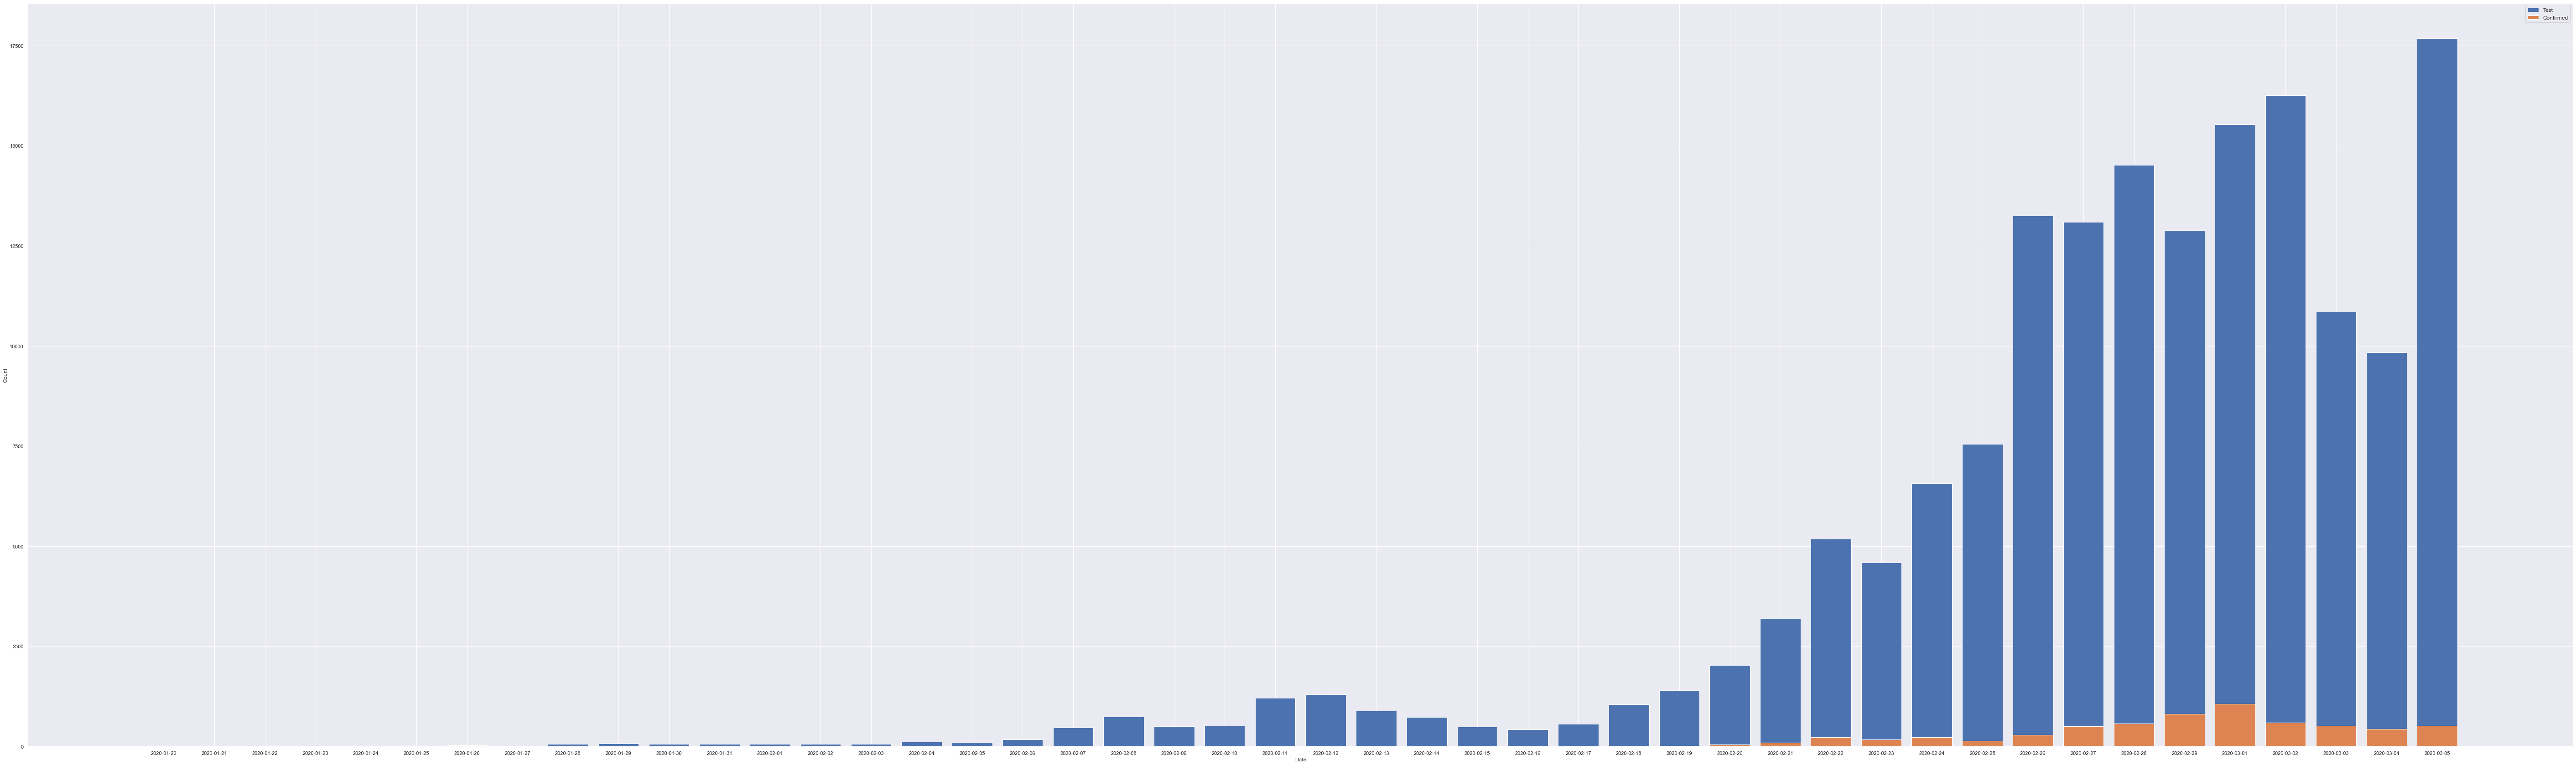

In [73]:
plt.figure(figsize=(100,30))
plt.bar(df_time.date, df_time.new_test,label="Test")
plt.bar(df_time.date, df_time.new_confirmed, label = "Confirmed")
plt.xlabel('Date')
plt.ylabel("Count")
plt.legend(frameon=True, fontsize=12)
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

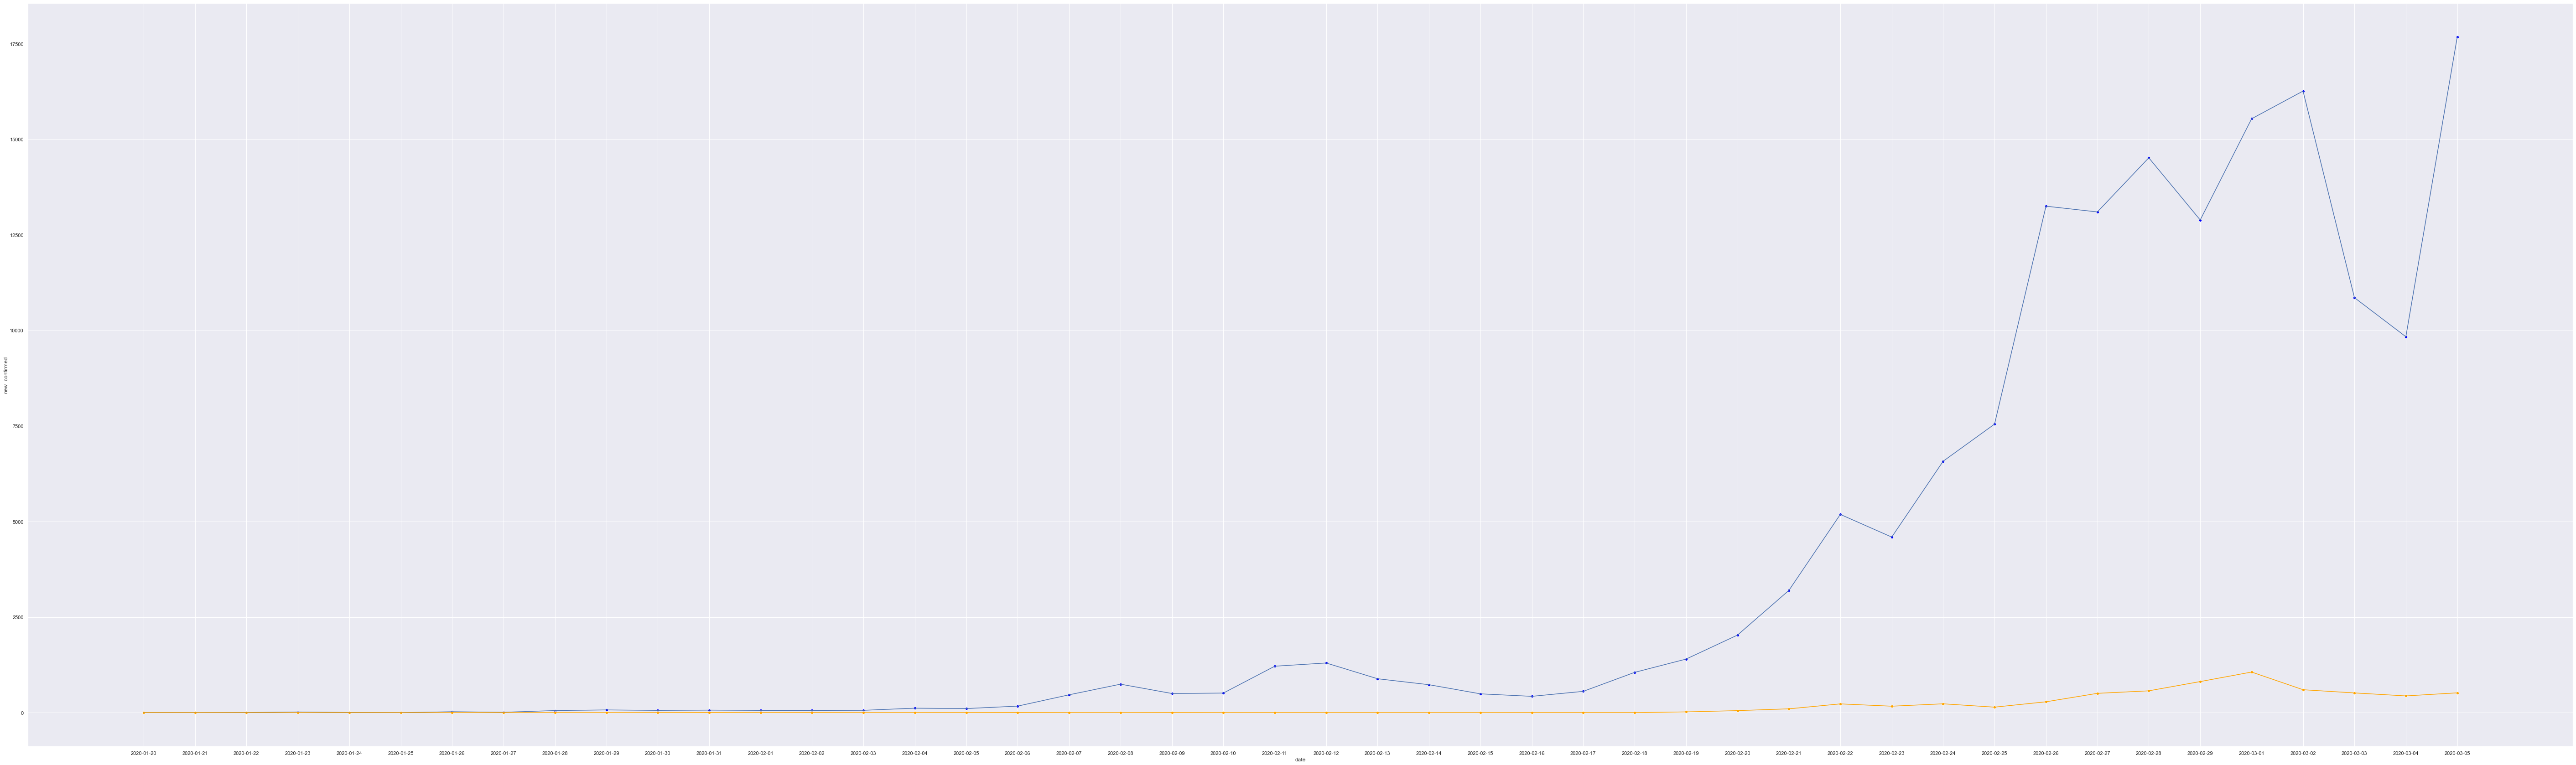

In [74]:
f, ax = plt.subplots(figsize=(100, 30))
ax=sns.scatterplot(x="date", y="new_test", data=df_time,
             color="blue")
ax=sns.scatterplot(x="date", y="new_confirmed", data=df_time,
             color="orange")


plt.plot(df_time.date,df_time.new_test,zorder=1)
plt.plot(df_time.date,df_time.new_confirmed,zorder=1,color="orange")

#### Graphical representaion of Confirmed vs State of Patient

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


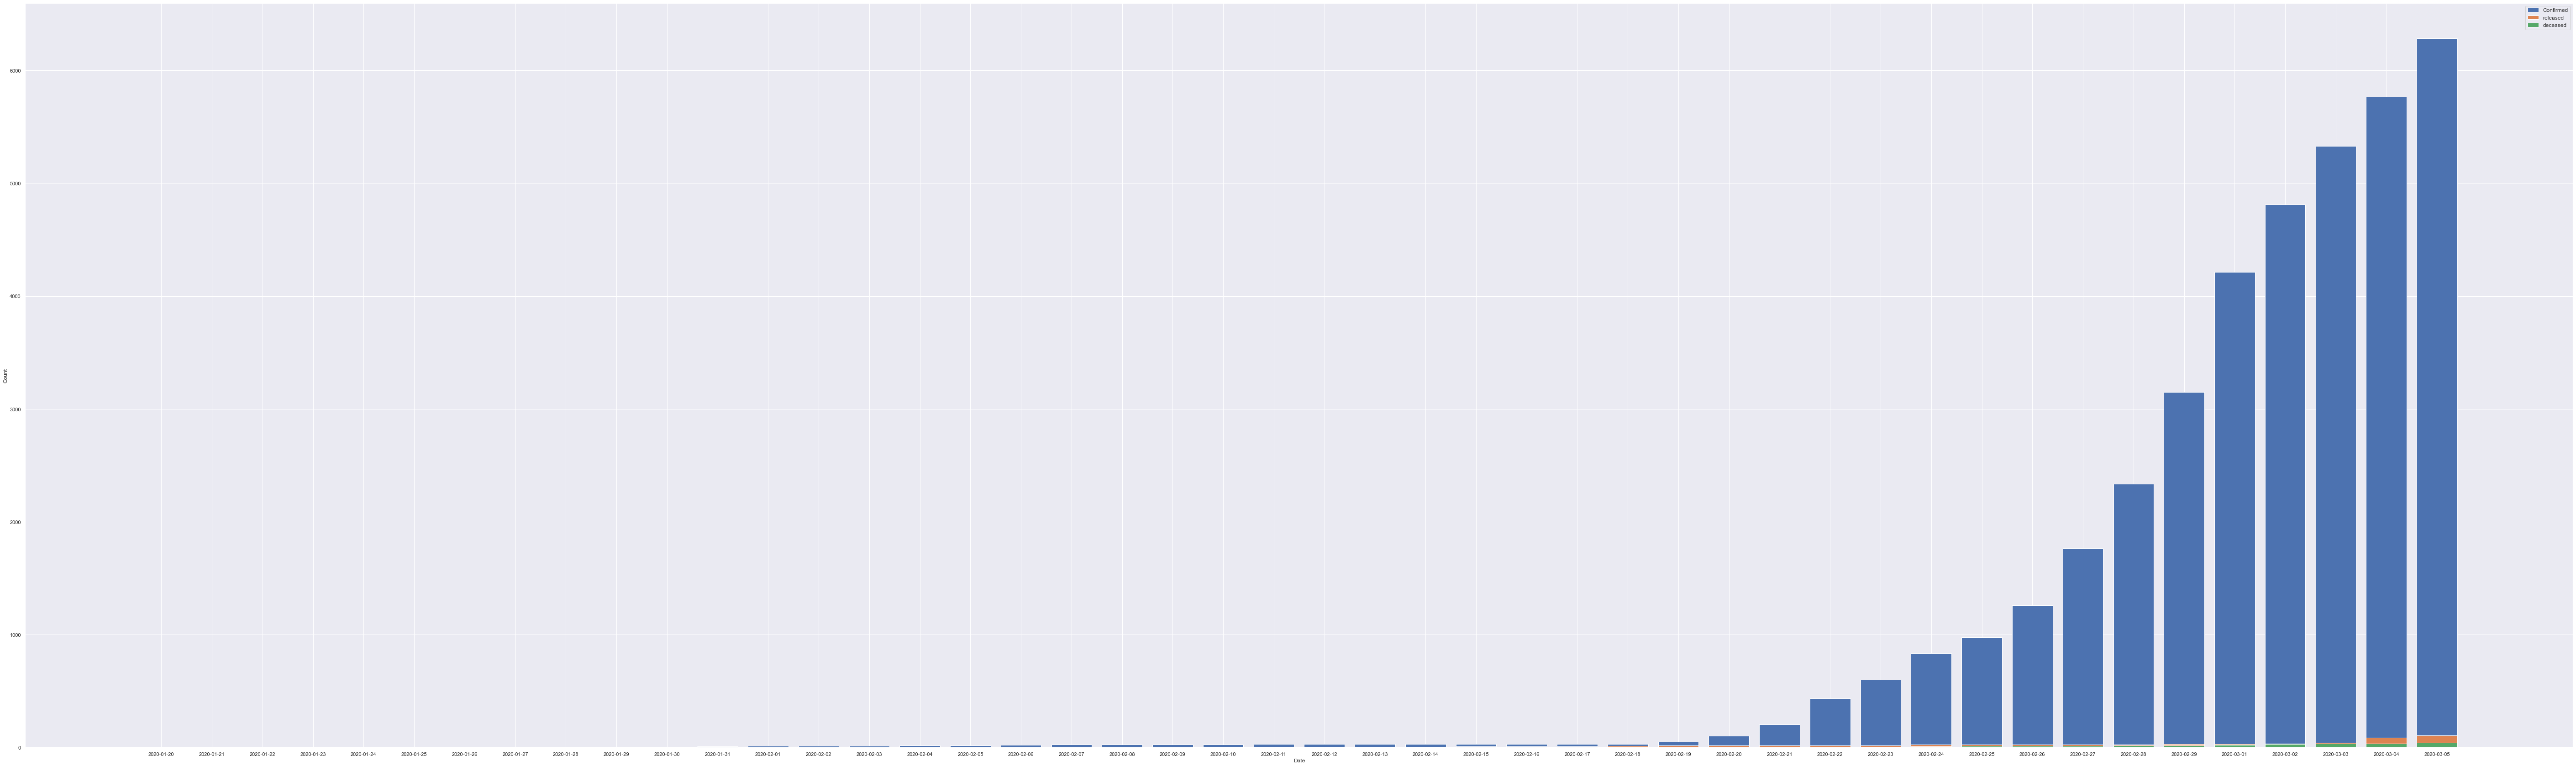

In [75]:
plt.figure(figsize=(100,30))
plt.bar(df_time.date, df_time.acc_confirmed, label = "Confirmed")
plt.bar(df_time.date, df_time.acc_released,label="released")
plt.bar(df_time.date, df_time.acc_deceased,label="deceased")
plt.xlabel('Date')
plt.ylabel("Count")
plt.legend(frameon=True, fontsize=12)
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

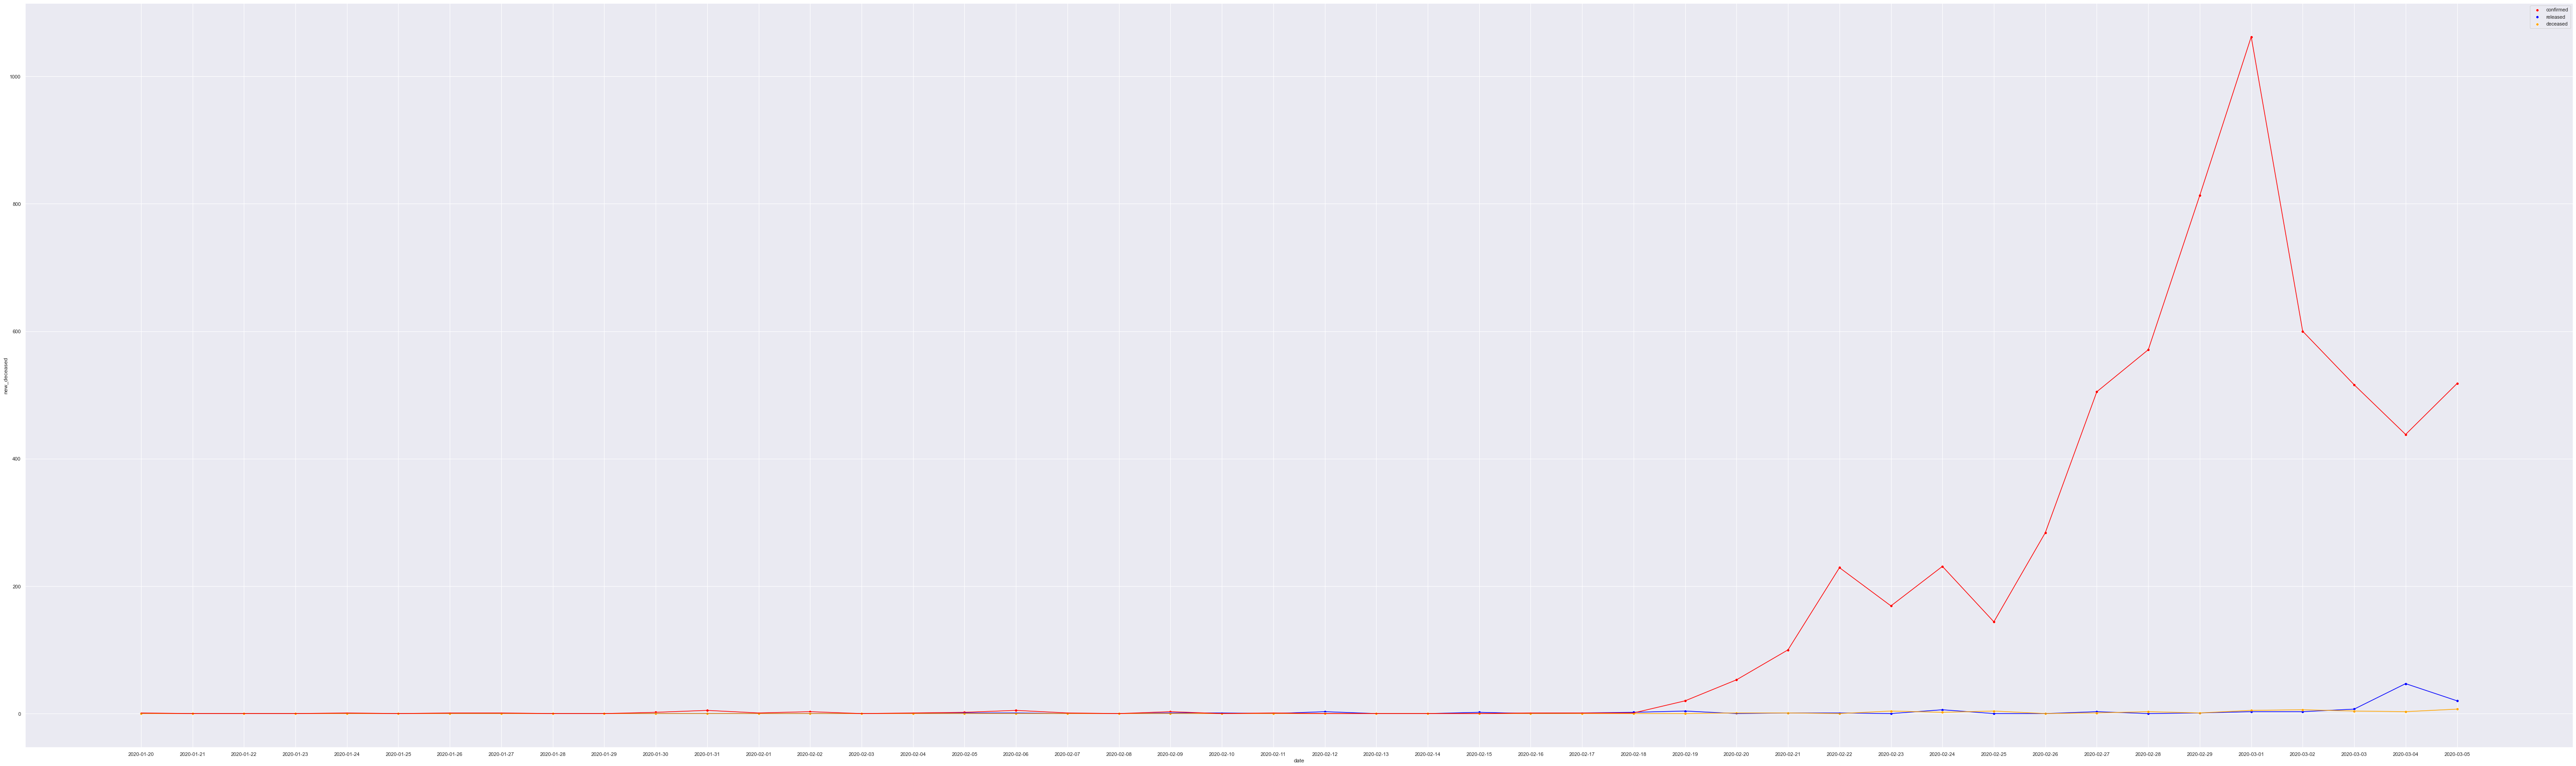

In [76]:
f, ax = plt.subplots(figsize=(100, 30))
ax=sns.scatterplot(x="date", y="new_confirmed", data=df_time,
             color="red",label = "confirmed")
ax=sns.scatterplot(x="date", y="new_released", data=df_time,
             color="blue",label = "released")
ax=sns.scatterplot(x="date", y="new_deceased", data=df_time,
             color="orange",label = "deceased")
plt.plot(df_time.date,df_time.new_released,zorder=1,color="blue")
plt.plot(df_time.date,df_time.new_deceased,zorder=1,color="orange")
plt.plot(df_time.date,df_time.new_confirmed,zorder=1,color="red")

#### Graphical representaion of new Confirmed vs State of Patient

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


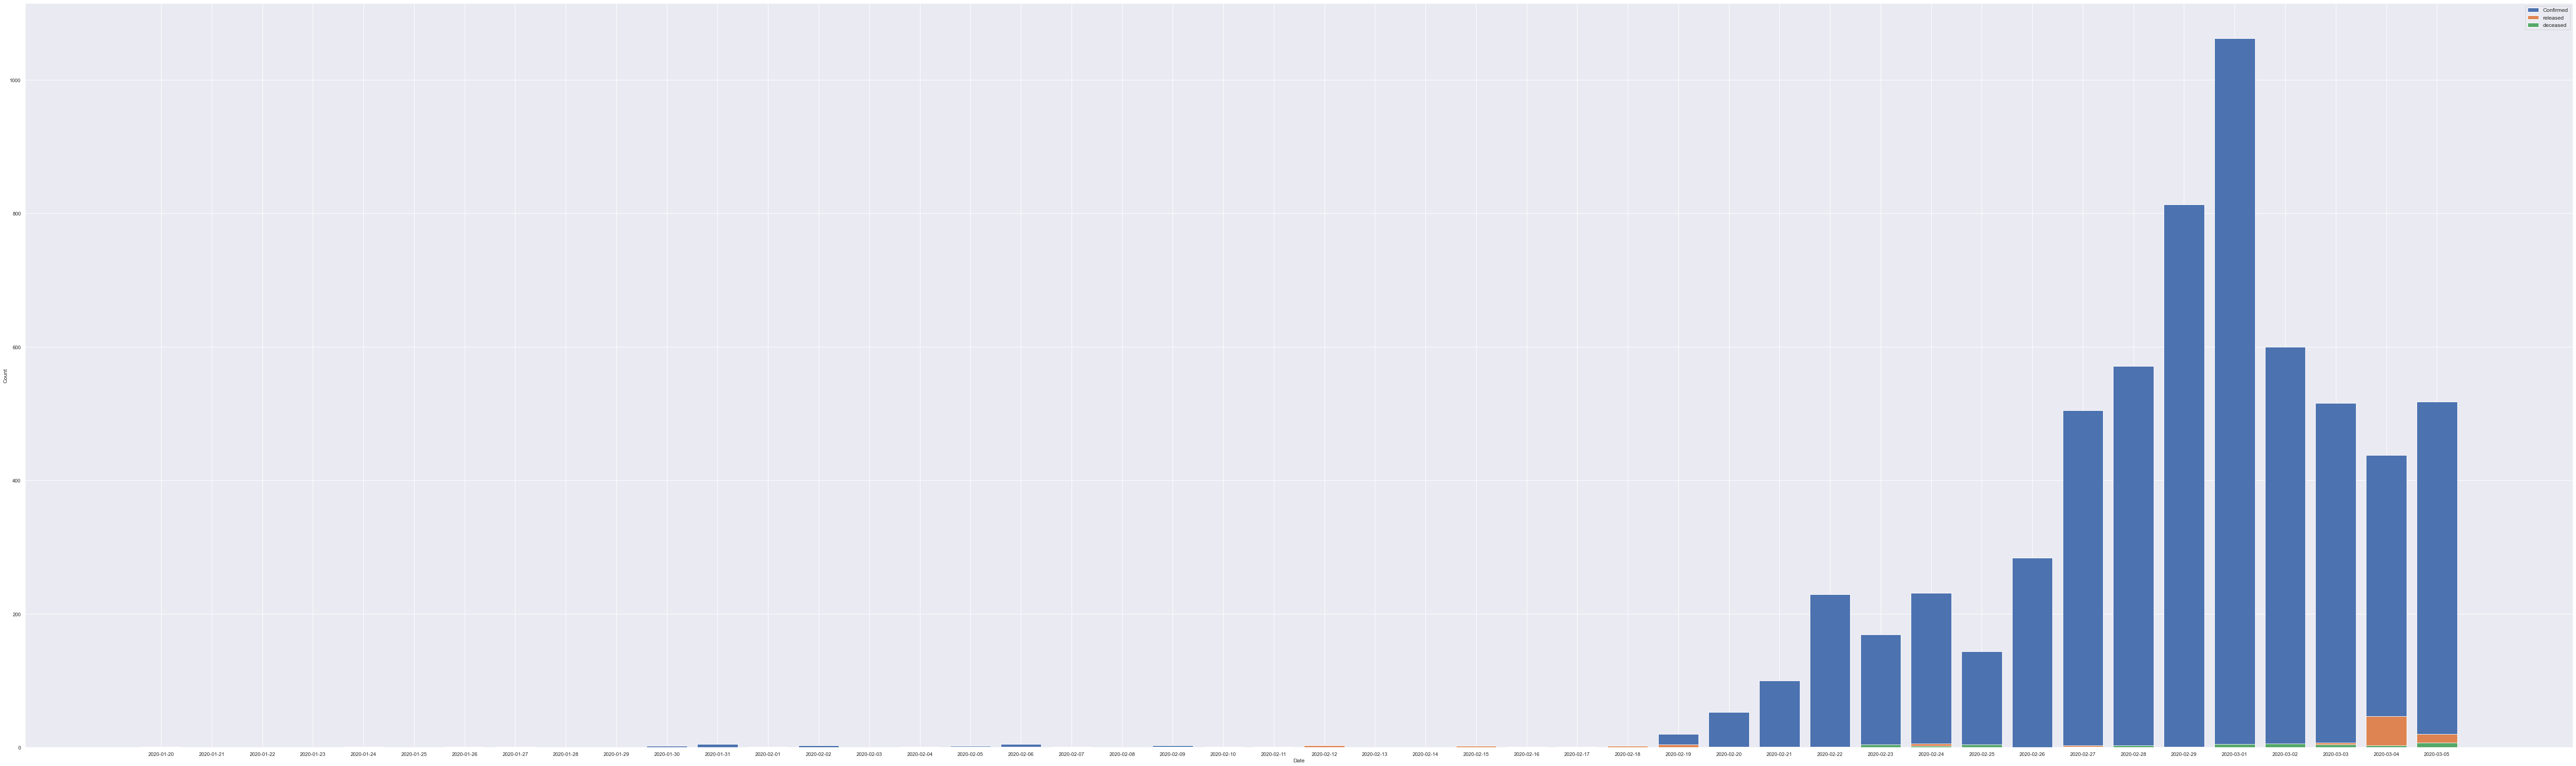

In [77]:
plt.figure(figsize=(100,30))
plt.bar(df_time.date, df_time.new_confirmed, label = "Confirmed")
plt.bar(df_time.date, df_time.new_released,label="released")
plt.bar(df_time.date, df_time.new_deceased,label="deceased")
plt.xlabel('Date')
plt.ylabel("Count")
plt.legend(frameon=True, fontsize=12)
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

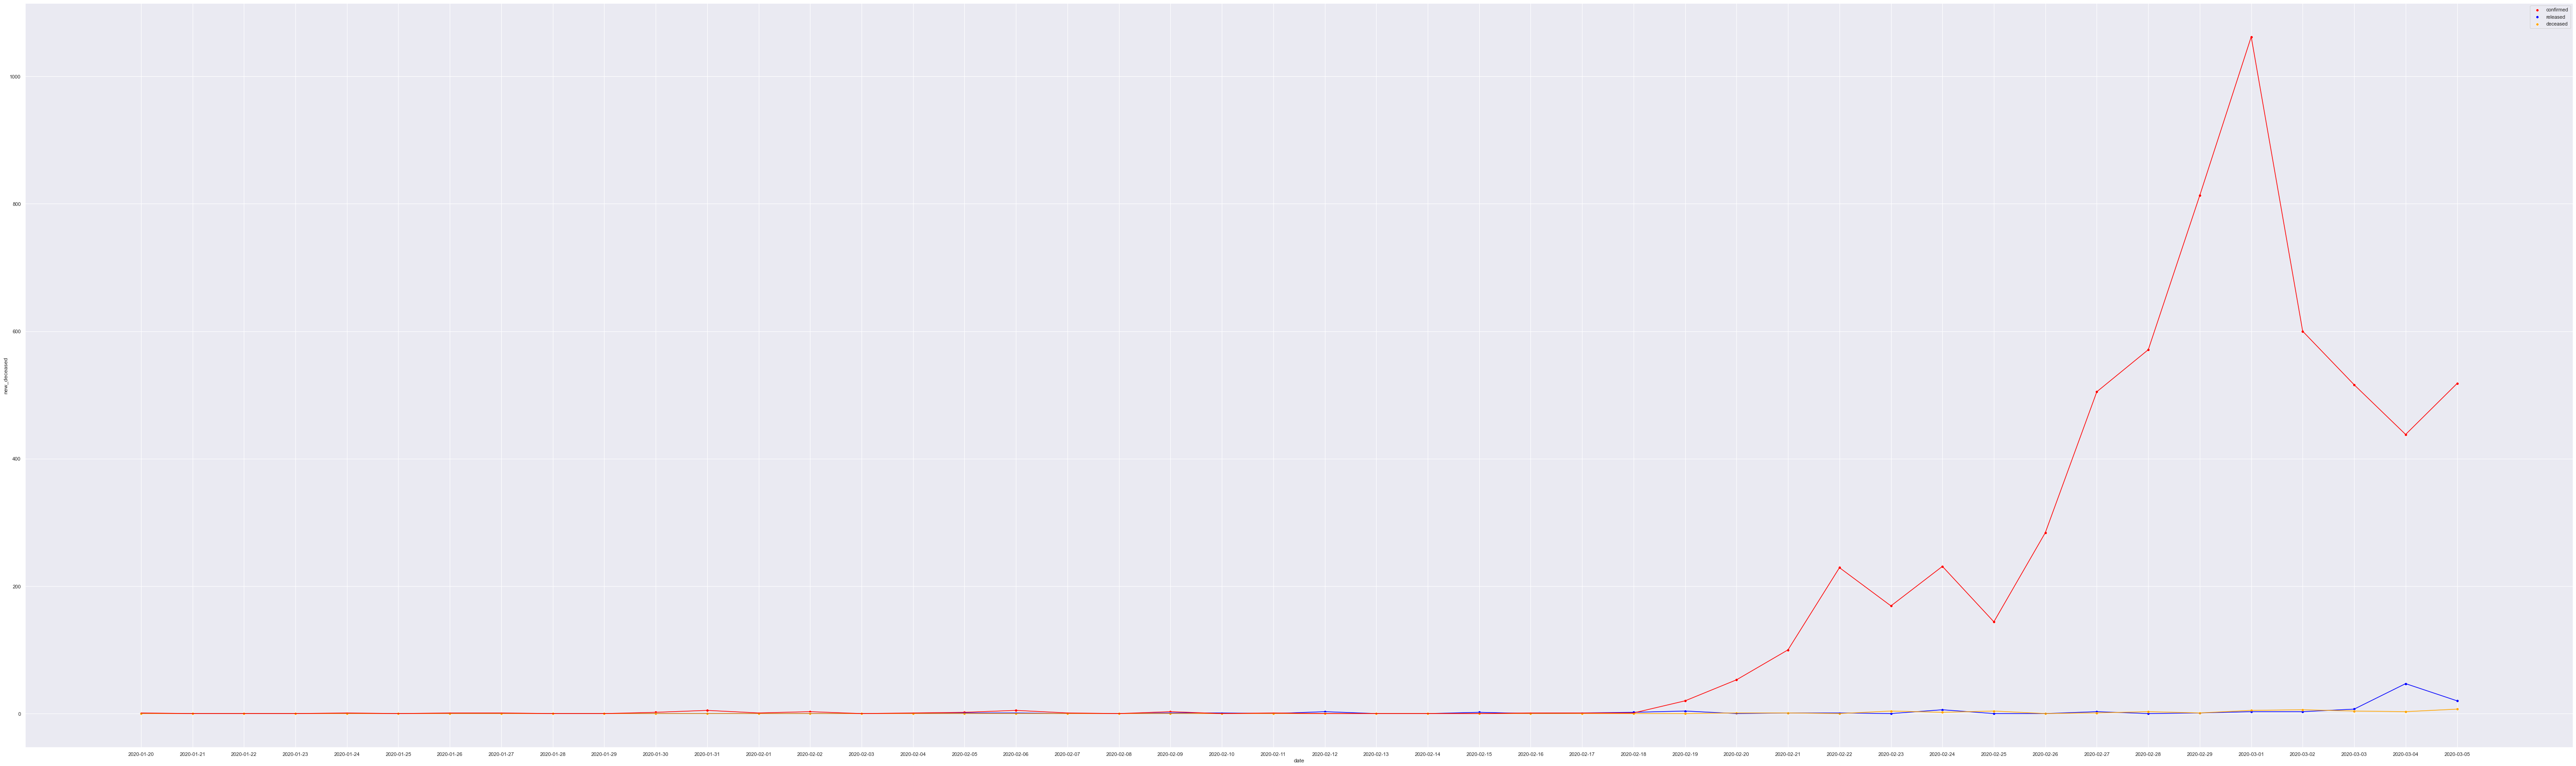

In [78]:
f, ax = plt.subplots(figsize=(100, 30))
ax=sns.scatterplot(x="date", y="new_confirmed", data=df_time,
             color="red",label = "confirmed")
ax=sns.scatterplot(x="date", y="new_released", data=df_time,
             color="blue",label = "released")
ax=sns.scatterplot(x="date", y="new_deceased", data=df_time,
             color="orange",label = "deceased")
plt.plot(df_time.date,df_time.new_released,zorder=1,color="blue")
plt.plot(df_time.date,df_time.new_deceased,zorder=1,color="orange")
plt.plot(df_time.date,df_time.new_confirmed,zorder=1,color="red")